## Testing the CALVADOS model against biophysical data

This notebook reproduces Extended Data Fig. 3

Authors: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [6]:
import numpy as np
import pandas as pd
import mdtraj as md
import os
from scipy import constants
from numpy import linalg
import glob
import seaborn as sns
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from ast import literal_eval
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pkg_resources
import string
import warnings
import MDAnalysis
from FRETpredict import FRETpredict
from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.filterwarnings('ignore')
hexcolors = ['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']
colornames = ['orange','blue','cyan','magenta','red','teal','grey']
pt_colors = dict(zip(colornames,hexcolors))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rc('pdf', fonttype=42)

def plotEnergyMap(ax,dmap,label,vmin,vmax,cmap=plt.cm.bwr,
            xlabel='Residue #',ylabel='Residue #',ori='vertical', #error bar can be vertical or horizontal
            cbar=True,n_ticks=4): #to show color gradient
    im = ax.imshow(dmap,extent=[1, dmap.shape[0], 1, dmap.shape[0]], 
                 cmap=cmap,
                 origin='lower',alpha=1,aspect='equal',
                 vmin=vmin,vmax=vmax) #makes bars
    if cbar:
        divider = make_axes_locatable(ax)
        if ori == 'vertical':
            cax = divider.new_horizontal(size="5%", pad=.1)
        else:
            cax = divider.new_vertical(size="5%", pad=.15)
        f.add_axes(cax)
        cb = f.colorbar(im, cax=cax, orientation=ori,
                    label=r'{:s}'.format(label))
        cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
        cb.set_ticks(np.linspace(vmin,vmax,4))
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    interval = round(dmap.shape[0]//n_ticks/10,0)*10
    if interval*4 > dmap.shape[0]:
        ax.set_xticks([1, interval, interval*2, interval*3])
        ax.set_yticks([1, interval, interval*2, interval*3])
    else:
        ax.set_xticks([1, interval, interval*2, interval*3, interval*4])
        ax.set_yticks([1, interval, interval*2, interval*3, interval*4])
    return cb

In [2]:
df_rg = pd.read_csv('md_simulations/data/tests/rg_test_data.csv',index_col=0)
df_rg = df_rg.sort_values('N',ascending=False)
df_rg.rel_rg_err_replicas = df_rg.rel_rg_err_replicas.apply(lambda x : literal_eval(x))
#df_rg['doi'].to_excel('../Supplementary_Table_4.xlsx')

In [3]:
df_ped = pd.read_csv('md_simulations/data/tests/PED_data.csv',index_col=0)
df_ped.loc[df_ped.drop('p27Kip1').index,'exp_rg'] = df_rg.loc[df_ped.drop('p27Kip1').index,'exp_rg'] 
df_ped.loc[df_ped.drop('p27Kip1').index,'exp_rg_err'] = df_rg.loc[df_ped.drop('p27Kip1').index,'exp_rg_err'] 

#### Load the FRET efficiency calculated using FRETpredict (see last cells of this notebook)

In [4]:
df_eff = pd.DataFrame(index=['Nup49','NLS','NUS','IBB','NUL','Sic1'])

for name,exp_E in zip(['Nup49','NLS','NUS','IBB','NUL'],[.87,.79,.53,.5,.48]):
    df_eff.loc[name,'E'] = pd.read_pickle(
        f'md_simulations/data/tests/all_atom/{name}-data-{df_ped.loc[name].N-1:d}-2.pkl'
        ).loc['Edynamic2','Average']
    df_eff.loc[name,'exp_E'] = exp_E
    
name = 'Sic1'
df_eff.loc[name,'E'] = pd.read_pickle(
    f'md_simulations/data/tests/all_atom/{name}-data-1-90.pkl'
    ).loc['Edynamic2','Average']
df_eff.loc[name,'exp_E'] = 0.42 # DOI: 10.1021/jacs.0c02088

#### Extended Data Fig. 3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

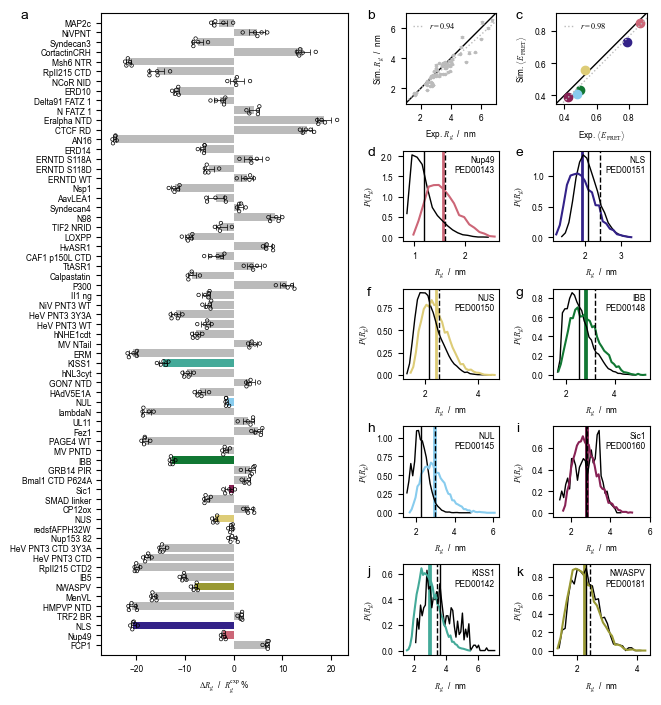

In [17]:
fig = plt.figure(figsize=(6.6,7))
ax1 = plt.subplot2grid( (5,4), (0,0), rowspan=5, colspan=2 )
ax2 = plt.subplot2grid( (5,4), (0,2), rowspan=1, colspan=1 )
ax3 = plt.subplot2grid( (5,4), (0,3), rowspan=1, colspan=1 )
ax4 = plt.subplot2grid( (5,4), (1,2), rowspan=1, colspan=1 )
ax5 = plt.subplot2grid( (5,4), (1,3), rowspan=1, colspan=1 )
ax6 = plt.subplot2grid( (5,4), (2,2), rowspan=1, colspan=1 )
ax7 = plt.subplot2grid( (5,4), (2,3), rowspan=1, colspan=1 )
ax8 = plt.subplot2grid( (5,4), (3,2), rowspan=1, colspan=1 )
ax9 = plt.subplot2grid( (5,4), (3,3), rowspan=1, colspan=1 )
ax10 = plt.subplot2grid( (5,4), (4,2), rowspan=1, colspan=1 )
ax11 = plt.subplot2grid( (5,4), (4,3), rowspan=1, colspan=1 )
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

colors = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499']

df_rg = df_rg.sort_values('N')

chi2 = np.power((df_rg.Rg-df_rg.exp_rg)/df_rg.exp_rg_err,2).mean()

mean_rel_rg_err = np.abs(df_rg['rel_rg_err']).median()

names = df_rg.index
labels = df_rg.index

ax1.barh(labels,df_rg.rel_rg_err, xerr=df_rg.rel_rg_err_std, height=.8,
        color=pt_colors['grey'], error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2,capthick=.5),
        label=r'$\langle |\Delta R_g$  /  $R_g^{\mathrm{exp}}|\rangle=$'+'{:.1f} %'.format(mean_rel_rg_err))

sns.swarmplot(ax=ax1,data=df_rg.reset_index().explode('rel_rg_err_replicas'),
              x='rel_rg_err_replicas',y='index',color='None',
              size=2.5,dodge=True,edgecolor='k',linewidth=.5,zorder=10,legend=False)

for seq_name,c in zip(['Nup49','NLS','NUS','IBB','NUL','Sic1','KISS1','NWASPV'],colors):
    ax1.barh(seq_name,df_rg.loc[seq_name].rel_rg_err,height=.8,
        color=c)

ax1.set_yticks(np.arange(df_rg.index.size))
ax1.set_yticklabels(labels=labels)
ax1.set_ylim(-1,df_rg.index.size)
ax1.set_xlabel(r'$\Delta R_g$  /  $R_g^{\mathrm{exp}}$ %')
ax1.set_ylabel('')

#############

pr = pearsonr(df_rg.exp_rg,df_rg.Rg)[0]
x = np.linspace(1,7,100)
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_rg.exp_rg,df_rg.Rg)
ax2.errorbar(df_rg.exp_rg,df_rg.Rg,df_rg.Rg_err,marker='o',
             ms=1.5,lw=0,elinewidth=.4,capsize=1.2,capthick=.4,color=pt_colors['grey'])
ax2.plot(x,popt[0]*x+popt[1],ls=':',lw=1,color=pt_colors['grey'],
         label='$r={:.2f}$'.format(pr))

ax2.legend(frameon=False,handlelength=1.1,loc='upper left')
ax2.set_xlim(1,7)
ax2.set_ylim(1,7)

ax2.plot(x,x,ls='-',color='k',lw=1,zorder=0)
ax2.set_aspect('equal')
ax2.set_xlabel('Exp. $R_g$  /  nm')
ax2.set_ylabel('Sim. $R_g$  /  nm')

#############

pr = pearsonr(df_eff.exp_E,df_eff.E)[0]
x = np.linspace(.2,1,100)
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_eff.exp_E,df_eff.E)

for seq_name,c in zip(['Nup49','NLS','NUS','IBB','NUL','Sic1'],colors):
    ax3.plot(df_eff.loc[seq_name].exp_E,df_eff.loc[seq_name].E,marker='o',ms=6,lw=0,
             color=c)

ax3.plot(x,popt[0]*x+popt[1],ls=':',lw=1,color=pt_colors['grey'],
         label='$r={:.2f}$'.format(pr))

ax3.legend(frameon=False,handlelength=1.1,loc='upper left')
ax3.set_xlim(.35,.91)
ax3.set_ylim(.35,.91)

ax3.plot(x,x,ls='-',color='k',lw=1,zorder=0)
ax3.set_aspect('equal')
ax3.set_xlabel(r'Exp. $\langle E_{\mathrm{FRET}} \rangle$')
ax3.set_ylabel(r'Sim. $\langle E_{\mathrm{FRET}} \rangle$')

#############

for seq_name,ax,c in zip(['Nup49','NLS','NUS','IBB','NUL','Sic1','KISS1','NWASPV'],
                       [ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11],colors):
    
    rg_ped = np.load(f'md_simulations/data/tests/PED_{seq_name:s}/rg.npy')
                    
    bins = np.arange(rg_ped.min(),rg_ped.max(),.1)
    x = bins[:-1]+(bins[1]-bins[0])/2.
    h,_ = np.histogram(rg_ped,bins=bins,density=True)

    ax.plot(x,h,lw=1,ms=2,color='k')
    
    rgarray = np.load(f'md_simulations/data/tests/{seq_name:s}_rgarray.npy')

    bins = np.arange(rgarray.min(),rgarray.max(),.1)
    x = bins[:-1]+(bins[1]-bins[0])/2.
    h,_ = np.histogram(rgarray,bins=bins,density=True)

    ax.plot(x,h,lw=1.5,color=c)
    
    ax.set_xlabel('$R_g$  /  nm')
    ax.set_ylabel('$P(R_g)$')
    
    legend = ax.legend(title=seq_name+'\n'+df_ped.loc[seq_name,'ped'],frameon=False,borderpad=0)
    legend.get_title().set_ha('right') 
    
    ax.axvspan(df_ped.loc[seq_name,'Rg']-df_ped.loc[seq_name,'Rg_err'], 
            df_ped.loc[seq_name,'Rg']+df_ped.loc[seq_name,'Rg_err'], 
            alpha=1, lw=2, color=c)
    
    ax.axvline(rg_ped.mean(), lw=1, color='k')
    
    ax.axvline(df_ped.loc[seq_name,'exp_rg'], ls='--', lw=1, color='k')
    
fig.text(0.03, .98, 'a', fontsize=10)
fig.text(0.555, .98, 'b', fontsize=10)
fig.text(0.78, .98, 'c', fontsize=10)
fig.text(0.555, .785, 'd', fontsize=10)
fig.text(0.78, .785, 'e', fontsize=10)
fig.text(0.555, .585, 'f', fontsize=10)
fig.text(0.78, .585, 'g', fontsize=10)
fig.text(0.555, .39, 'h', fontsize=10)
fig.text(0.78, .39, 'i', fontsize=10)
fig.text(0.555, .185, 'j', fontsize=10)
fig.text(0.78, .185, 'k', fontsize=10)

ax5.set_xlim(1.1,3.8)
ax9.set_xlim(1.1,6)

ax1.set_yticks(np.arange(df_rg.index.size), [name.replace('_',' ')
                   for name in df_rg.index], rotation=0)

plt.tight_layout()

plt.savefig('figs/ED_fig3.jpg',dpi=600)

## FRETpredict calculations (DOI: 10.1101/2023.01.27.525885v1)

#### Predict FRET efficiencies for Sic1

In [ ]:
for name in ['Sic1']:
    # Create a MDAnalysis.Universe object for the protein structure.
    u = MDAnalysis.Universe('md_simulations/data/tests/all_atom/'+name+'.pdb', 
                            'md_simulations/data/tests/all_atom/'+name+'.xtc')

    # Create instance of the FRETpredict class
    FRET = FRETpredict(protein=u, residues=[1,90], chains=['A', 'A'], temperature=293, 
                       donor='AlexaFluor 488', acceptor='AlexaFluor 647', electrostatic=True,
                       libname_1=f'AlexaFluor 488 C1R cutoff20',
                       libname_2=f'AlexaFluor 647 C2R cutoff20',  
                       output_prefix='md_simulations/data/tests/all_atom/'+name)

    # Run FRET efficiency calculations.
    FRET.run()

#### Predict FRET efficiencies for IDRs labeled as in Fuertes et al. (DOI: 10.1073/pnas.1704692114)

In [ ]:
for name in ['NLS','NUS','IBB','NUL','Nup49']:
    # Create a MDAnalysis.Universe object for the protein structure.
    u = MDAnalysis.Universe('md_simulations/data/tests/all_atom/'+name+'.pdb', 
                            'md_simulations/data/tests/all_atom/'+name+'.xtc')

    # Create instance of the FRETpredict class
    FRET = FRETpredict(protein=u, residues=[df_ped.loc[name].N-1,2], chains=['A', 'A'], temperature=296, 
                       donor='AlexaFluor 488', acceptor='AlexaFluor 594', electrostatic=True,
                       libname_1=f'AlexaFluor 488 C1R cutoff20',
                       libname_2=f'AlexaFluor 594 C1R cutoff20',  
                       output_prefix='md_simulations/data/tests/all_atom/'+name)

    # Run FRET efficiency calculations.
    FRET.run()

#### Predict FRET efficiencies for IDRs labeled as in Fuertes et al. and using the R0 values reported in the paper

In [ ]:
for name,R0 in zip(['Nup49','NLS','NUS','IBB','NUL'],[5.40,5.56,5.67,5.56,5.65]):
    # Create a MDAnalysis.Universe object for the protein structure.
    u = MDAnalysis.Universe('md_simulations/data/tests/all_atom/'+name+'.pdb', 
                            'md_simulations/data/tests/all_atom/'+name+'.xtc')

    # Create instance of the FRETpredict class
    FRET = FRETpredict(protein=u, residues=[df_ped.loc[name].N-1,2], chains=['A', 'A'], temperature=296, 
                       donor='AlexaFluor 488', acceptor='AlexaFluor 594', electrostatic=True,
                       libname_1=f'AlexaFluor 488 C1R cutoff20',
                       libname_2=f'AlexaFluor 594 C1R cutoff20', 
                       fixed_R0=True, r0=R0, 
                       output_prefix='md_simulations/data/tests/all_atom/'+name+f'_R0{R0:.2f}')

    # Run FRET efficiency calculations.
    FRET.run()